In [ ]:
! pip install openpyxl torch numpy pandas seaborn scikit-learn scipy matplotlib transformers gensim

In [4]:
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from gensim.utils import simple_preprocess
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix

import torch.nn as nn
from torch.optim import AdamW
from torch.utils.data import Dataset, DataLoader

from transformers import get_linear_schedule_with_warmup, AutoTokenizer, AutoModel, logging

import warnings
warnings.filterwarnings("ignore")

logging.set_verbosity_error()

/home/anhcd/miniconda3/envs/bert/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def seed_everything(seed_value):
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    
    if torch.cuda.is_available(): 
        print("Torch available")
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = True

seed_everything(86)

Torch available


In [8]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
EPOCHS = 30
N_SPLITS = 5

# Load Data

In [4]:
def get_data(path):
    if path.lower().endswith(".csv"):
        df = pd.read_csv(path)
    elif path.lower().endswith(".xlsx"):
        df = pd.read_excel(path, sheet_name=None)['Sheet1']
    df.columns = ['id', 'text', 'label']
    # unused column
    df.drop(columns=['id'], inplace=True)
    return df

all_df = get_data('/home/anhcd/Products/kiem-duyet-noi-dung-van-ban-tieng-viet/data/data_all.csv')
all_df = all_df[['text', 'label']]

In [5]:
all_df = all_df.dropna()

In [6]:
from sklearn.model_selection import train_test_split

# Sử dụng train_test_split để phân chia dữ liệu
train_df, test_df = train_test_split(all_df, test_size=0.1, stratify=all_df['label'], random_state=42)

# Kiểm tra kết quả
print(f"Train DataFrame size: {train_df.shape}")
print(f"Test DataFrame size: {test_df.shape}")

Train DataFrame size: (11965, 2)
Test DataFrame size: (1330, 2)


In [7]:
train_df = train_df.reset_index(drop=True)
train_df

text      label
0      – Toản đừng Toản …Loan sợ quá .Nàng bỗng kêu t...       khac
1                                                             khac
2                             Lam_Phuong 1 pha tấu hài        khac
3                           Tiếc dziên hơi nhiều nha bác       khac
4                                Ủa bây_giờ mới biết sao       khac
...                                                  ...        ...
11960                                       A Di_Đà_Phật       khac
11961  – Dũng có thích Phượng không ?Chị nghĩ Phượng ...  khieu_dam
11962                                 Tân_AK xin video ạ       khac
11963          Tình_hình là chưa được lên fan cứng anh ạ       khac
11964       1tr súp rồi nhớ giữ lời hứa năm_xưa nha thầy       khac

[11965 rows x 2 columns]

In [8]:
test_df = test_df.reset_index(drop=True)
test_df

text      label
0     Nhớ hồi trước Hùng và Nguyệt phải chạy_đôn_chạ...       khac
1                                    chúc_mừng thầy nha       khac
2                      Chuc ong tran dan nhieu suc khoe       khac
3     Tôi đứng ra phía sau , tụt quần_lót em xuống ,...  khieu_dam
4                                         Cướp ngày đấy       khac
...                                                 ...        ...
1325                                 Nhận phong_bì thôi       khac
1326  Hieu_Anh thích mấy bài sâu_lắng , nếu sau_này ...       khac
1327  Khi thấy Kiều_Oanh càng cựa_quậy thân_hình thì...  khieu_dam
1328                                      Hàng Fake bạn       khac
1329  Mẹ tôi hứ một tiếng tôi mới từ sau ôm mẹ hai b...  khieu_dam

[1330 rows x 2 columns]

In [9]:
# We will use Kfold later
# train_df = pd.concat([train_df, valid_df], ignore_index=True)
skf = StratifiedKFold(n_splits=N_SPLITS)
for fold, (_, val_) in enumerate(skf.split(X=train_df, y=train_df.label)):
    train_df.loc[val_, "kfold"] = fold

In [10]:
train_df.sample(10)

text      label  kfold
4684                                  nghe mắc_cười quá       khac    1.0
7876   Ngay sau khi tập_trung vào_cuộc truy_hoan , co...  khieu_dam    3.0
11641  Dìu_Dũng vào trong phòng của nó , Nguyệt đặt n...  khieu_dam    4.0
7716                                     : ) ) ) ) ) ) )       khac    3.0
937    Tôi lại bật phim sex cho chị xem .Bộ phim này ...  khieu_dam    0.0
11926                              Minh_Hoàng chill phết       khac    4.0
5948                              Coronavirus is manmade       khac    2.0
7883   Bú liếm một hồi , Trang đứng dậy cởi chiếc quầ...  khieu_dam    3.0
3889                               Ae sống chậm lại đi        khac    1.0
5015                        Có_vẻ là người nổi_tiếng : v       khac    2.0

In [11]:
train_df.info(), test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11965 entries, 0 to 11964
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   text    11965 non-null  object 
 1   label   11965 non-null  object 
 2   kfold   11965 non-null  float64
dtypes: float64(1), object(2)
memory usage: 280.6+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1330 entries, 0 to 1329
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    1330 non-null   object
 1   label   1330 non-null   object
dtypes: object(2)
memory usage: 20.9+ KB


(None, None)

In [12]:
sns.countplot(x='label', data=train_df)

<Axes: xlabel='label', ylabel='count'>

# DataLoader

In [14]:
tokenizer = AutoTokenizer.from_pretrained("/home/anhcd/Data/phobert-base/", local_files_only=True, use_fast=False)

In [14]:
class ClassifyDataset(Dataset):
    def __init__(self, df, tokenizer, classes, max_len=258):
        self.df = df
        self.max_len = max_len
        self.tokenizer = tokenizer
        self.classes = classes
    
    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        """
        To customize dataset, inherit from Dataset class and implement
        __len__ & __getitem__
        __getitem__ should return 
            data:
                input_ids
                attention_masks
                text
                targets
        """
        row = self.df.iloc[index]
        text, label = self.get_input_data(row)

        # Encode_plus will:
        # (1) split text into token
        # (2) Add the '[CLS]' and '[SEP]' token to the start and end
        # (3) Truncate/Pad sentence to max length
        # (4) Map token to their IDS
        # (5) Create attention mask
        # (6) Return a dictionary of outputs
        encoding = self.tokenizer.encode_plus(
            text,
            truncation=True,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            return_attention_mask=True,
            return_token_type_ids=False,
            return_tensors='pt',
        )
        
        return {
            'text': text,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_masks': encoding['attention_mask'].flatten(),
            'targets': torch.tensor(label, dtype=torch.long),
        }


    def labelencoder(self,text):
        for i in range(len(self.classes)):
            if text == self.classes[i]:
                return i

    def get_input_data(self, row):
        # Preprocessing: {remove icon, special character, lower}
        text = row['text']
        text = ' '.join(simple_preprocess(text))
        label = self.labelencoder(row['label'])

        return text, label

In [9]:
import yaml 

def get_data_from_yaml(filename):
    try:
        with open(filename, 'r') as f:
            data = yaml.safe_load(f)
    except IOError:
        raise IOError(f"Error opening file: {filename}")

    return data

# Example usage
config = get_data_from_yaml("../config.yaml")

# Access data based on its structure (e.g., dictionary)
if isinstance(config, dict):
    print(config)
    CLASSES = config.get("classes")
    MINIO_SERVER = config.get("minio")["server"]
    MINIO_DATA_LABELED = config.get("minio")["data_labeled"]
    MINIO_MODEL_TRAINED = config.get("minio")["model_trained"]
    VNCORENLP_DIR = config.get("vncorenlp")["save_dir"]
else:
    print("Config is not a dictionary")

{'device': 'cuda', 'classes': ['khac', 'phan_dong', 'thu_ghet', 'khieu_dam'], 'model_checkpoint': '/home/anhcd/Products/kiem-duyet-noi-dung-van-ban-tieng-viet/model/phobert_fold1.pth', 'chunk_size': 200, 'vocab': 'aAàÀảẢãÃáÁạẠăĂằẰẳẲẵẴắẮặẶâÂầẦẩẨẫẪấẤậẬbBcCdDđĐeEèÈẻẺẽẼéÉẹẸêÊềỀểỂễỄếẾệỆfFgGhHiIìÌỉỈĩĨíÍịỊjJkKlLmMnNoOòÒỏỎõÕóÓọỌôÔồỒổỔỗỖốỐộỘơƠờỜởỞỡỠớỚợỢpPqQrRsStTuUùÙủỦũŨúÚụỤưƯừỪửỬữỮứỨựỰvVwWxXyYỳỲỷỶỹỸýÝỵỴzZ0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~ ', 'minio': {'server': '172.18.0.2:9000', 'data_labeled': 'data-annotated', 'model_trained': 'model'}, 'vncorenlp': {'save_dir': '/home/anhcd/Software/VnCoreNLP/'}, 'phobert_base': {'save_dir': '/home/anhcd/Data/phobert-base/', 'max_token_length': 256}, 'training': {'epoch': 100, 'k_fold': 5}}


In [10]:
classes = CLASSES
print(len(classes))
print(classes)

4
['khac', 'phan_dong', 'thu_ghet', 'khieu_dam']


BERT works with fixed-length sequences. We’ll use a simple strategy to choose the max length.

Text(0.5, 9.444444444444438, 'Token Count')

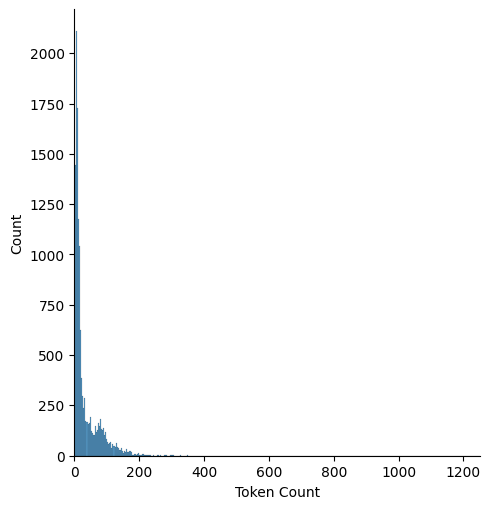

In [18]:
# Distribution of length of Sentence
all_data = train_df.text.tolist() + test_df.text.tolist()
all_data = [' '.join(simple_preprocess(text)) for text in all_data]
encoded_text = [tokenizer.encode(text, add_special_tokens=True) for text in all_data]
token_lens = [len(text) for text in encoded_text]
sns.displot(token_lens)
plt.xlim([0,max(token_lens)])
plt.xlabel('Token Count')

In [21]:
for i, len in enumerate(token_lens):
    text = str(all_data[i])
    words = text.split(' ')
    no = 0
    for w in words:
        no += 1
    print(text)
    print(f'len: {no}')
    print(f'token len: {token_lens[i]}')
    print('-----------------------')

toản đừng toản loan sợ quá nàng bỗng kêu thốt lên trong hồi_hộp
len: 13
token len: 17
-----------------------

len: 1
token len: 2
-----------------------
lam_phuong pha tấu hài
len: 4
token len: 8
-----------------------
tiếc dziên hơi nhiều nha bác
len: 6
token len: 9
-----------------------
ủa bây_giờ mới biết sao
len: 5
token len: 7
-----------------------
thôi đi thím cán bọi bị bắt thì phải mất vài trăm triệu chạy_án thì mới mong yên_ổn
len: 18
token len: 21
-----------------------
miền tây từ một vùng_đất sầm_uất trù_phú nay bỗng tiêu_điều người_dân phải phiêu_bạt tứ_tán
len: 14
token len: 18
-----------------------
tùng vạch bờ cỏ phía dưới lồn nàng có_lẽ lần này tùng mới để_ý kỹ cái lồn của nàng lồn nàng xinh quá mép lồn như hai mép của con sò đang gập lại với nhau dúi mũi ngửi thì nó thum_thủm cái mùi mà biết_bao_nhiêu đàn_ông đã mê chết_mê mệt cái mùi kỳ_diệu này
len: 55
token len: 64
-----------------------
nghe có_vẻ đáng yêu nhunge lại raats dễ_thương
len: 8
token len: 12

# Model

In [6]:
class BERTClassifier(nn.Module):
    def __init__(self, n_classes):
        super(BERTClassifier, self).__init__()
        self.bert = AutoModel.from_pretrained("/home/anhcd/Data/phobert-base/", local_files_only=True)
        self.drop = nn.Dropout(p=0.3)
        self.fc = nn.Linear(self.bert.config.hidden_size, n_classes)
        nn.init.normal_(self.fc.weight, std=0.02)
        nn.init.normal_(self.fc.bias, 0)

    def forward(self, input_ids, attention_mask):
        last_hidden_state, output = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask,
            return_dict=False # Dropout will errors if without this
        )

        x = self.drop(output)
        x = self.fc(x)
        return x

# Train & Eval Function

In [20]:
def train(model, criterion, optimizer, train_loader, lr_scheduler):
    model.train()
    losses = []
    correct = 0

    for data in train_loader:
        if data is not None:         
            input_ids = data['input_ids'].to(device)
            attention_mask = data['attention_masks'].to(device)
            targets = data['targets'].to(device)

            optimizer.zero_grad()
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )

            loss = criterion(outputs, targets)
            _, pred = torch.max(outputs, dim=1)

            correct += torch.sum(pred == targets)
            losses.append(loss.item())
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            lr_scheduler.step()
        else:
            print("Warning: Empty data received from data loader. Skipping this iteration.")

    print(f'Train Accuracy: {correct.double()/len(train_loader.dataset)} Loss: {np.mean(losses)}')

def eval(model, valid_loader, criterion):
    model.eval()
    losses = []
    correct = 0

    with torch.no_grad():
        for data in valid_loader:
            input_ids = data['input_ids'].to(device)
            attention_mask = data['attention_masks'].to(device)
            targets = data['targets'].to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )

            _, pred = torch.max(outputs, dim=1)

            loss = criterion(outputs, targets)
            correct += torch.sum(pred == targets)
            losses.append(loss.item())
    
    print(f'Valid Accuracy: {correct.double()/len(valid_loader.dataset)} Loss: {np.mean(losses)}')
    return correct.double()/len(valid_loader.dataset)

# Training with K-Fold

In [21]:
def prepare_loaders(df, fold):
    df_train = df[df.kfold != fold].reset_index(drop=True)
    df_valid = df[df.kfold == fold].reset_index(drop=True)
    
    train_dataset = ClassifyDataset(df_train, tokenizer, classes, max_len=256)
    valid_dataset = ClassifyDataset(df_valid, tokenizer, classes, max_len=256)
    
    train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=2)
    valid_loader = DataLoader(valid_dataset, batch_size=16, shuffle=True, num_workers=2)
    
    return train_loader, valid_loader

In [22]:
for fold in range(skf.n_splits):
    print(f'-----------Fold: {fold+1} ------------------')
    train_loader, valid_loader = prepare_loaders(train_df, fold=fold)
    model = BERTClassifier(n_classes=len(CLASSES)).to(device)
    criterion = nn.CrossEntropyLoss()
    # Recommendation by BERT: lr: 5e-5, 2e-5, 3e-5
    # Batchsize: 16, 32
    optimizer = AdamW(model.parameters(), lr=2e-5)
    
    lr_scheduler = get_linear_schedule_with_warmup(
                optimizer, 
                num_warmup_steps=0, 
                num_training_steps=len(train_loader)*EPOCHS
            )
    best_acc = 0
    for epoch in range(EPOCHS):
        print(f'Epoch {epoch+1}/{EPOCHS}')
        print('-'*30)

        train(model, criterion, optimizer, train_loader, lr_scheduler)
        val_acc = eval(model, valid_loader, criterion)

        torch.save(model.state_dict(), f'/home/anhcd/Products/kiem-duyet-noi-dung-van-ban-tieng-viet/model/phobert_fold{fold+1}_last.pth')

        if val_acc > best_acc:
            torch.save(model.state_dict(), f'/home/anhcd/Products/kiem-duyet-noi-dung-van-ban-tieng-viet/model/phobert_fold{fold+1}_best.pth')
            best_acc = val_acc

-----------Fold: 1 ------------------
Epoch 1/30
------------------------------


KeyboardInterrupt: 

In [27]:
def test(data_loader):
    models = []
    for fold in range(skf.n_splits):
        model = BERTClassifier(n_classes=len(CLASSES))
        model.to(device)
        model.load_state_dict(torch.load(f'phobert_fold{fold+1}.pth'))
        model.eval()
        models.append(model)

    texts = []
    predicts = []
    predict_probs = []
    real_values = []

    for data in data_loader:
        text = data['text']
        input_ids = data['input_ids'].to(device)
        attention_mask = data['attention_masks'].to(device)
        targets = data['targets'].to(device)

        total_outs = []
        for model in models:
            with torch.no_grad():
                outputs = model(
                    input_ids=input_ids,
                    attention_mask=attention_mask
                )
                total_outs.append(outputs)
        
        total_outs = torch.stack(total_outs)
        _, pred = torch.max(total_outs.mean(0), dim=1)
        texts.extend(text)
        predicts.extend(pred)
        predict_probs.extend(total_outs.mean(0))
        real_values.extend(targets)
    
    predicts = torch.stack(predicts).cpu()
    predict_probs = torch.stack(predict_probs).cpu()
    real_values = torch.stack(real_values).cpu()
    print(classification_report(real_values, predicts))
    return real_values, predicts

In [28]:
test_dataset = ClassifyDataset(test_df, tokenizer, classes, max_len=256)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=True, num_workers=2)
real_values, predicts = test(test_loader)

              precision    recall  f1-score   support

           0       0.63      0.86      0.73       898
           1       0.12      0.05      0.07        44
           2       0.55      0.55      0.55       485
           3       0.88      0.17      0.29       383

    accuracy                           0.61      1810
   macro avg       0.55      0.41      0.41      1810
weighted avg       0.65      0.61      0.57      1810



Visualize Wrong Predicted Label

In [29]:
sns.heatmap(confusion_matrix(real_values, predicts), annot=False, xticklabels = classes, yticklabels = classes)

<Axes: >

In [30]:
def check_wrong(real_values, predicts):
    wrong_arr = []
    wrong_label = []
    for i in range(len(predicts)):
        if predicts[i] != real_values[i]:
            wrong_arr.append(i)
            wrong_label.append(predicts[i])
    return wrong_arr, wrong_label

for i in range(15):
    print('-'*50)
    wrong_arr, wrong_label = check_wrong(real_values, predicts)
    print(test_df.iloc[wrong_arr[i]].text)
    print(f'Predicted: ({classes[wrong_label[i]]}) --vs-- Real label: ({classes[real_values[wrong_arr[i]]]})')

--------------------------------------------------
Không làm _ sao có ăn
Predicted: (khac) --vs-- Real label: (khieu_dam)
--------------------------------------------------
Phục _ vụ cho cộng _ sản , mà ko mang lợi cho chúng , những người này kì _ vọng gì , mong chúng nhân _ từ đưa ra miếng xương sao
Predicted: (phan_cam) --vs-- Real label: (khieu_dam)
--------------------------------------------------
đất nước mình như tảng băng chìm .Loạn lạc quá ! ba mẹ đi làm quần quật kiếm tiền , các thuế phí xăng thì tăng vùn vụt mà lương thì không thấy tăng , con cái đi học thì bị bảo vệ / thầy .. bạo hành , lạm dụng td .Bị phát
Predicted: (khac) --vs-- Real label: (phan_cam)
--------------------------------------------------
Rồi một luồng tinh_khí phóng thật mạnh vào lồn con đĩ .Con đĩ sướng quá nằm rên_rỉ , hắn cũng phê quá nằm đè lên mình của con đĩ .Chưa có lần nào mà Trực chơi sướng như lần này , hắn chịu trả thêm cho con đĩ 1 triệu và chơi cho hết cả đêm

# Inference

In [16]:
def infer(text, model, tokenizer, class_names, max_len=256):
    encoded_review = tokenizer.encode_plus(
        text,
        max_length=max_len,
        truncation=True,
        add_special_tokens=True,
        padding='max_length',
        return_attention_mask=True,
        return_token_type_ids=False,
        return_tensors='pt',
    )

    input_ids = encoded_review['input_ids'].to(device)
    attention_mask = encoded_review['attention_mask'].to(device)

    output = model(input_ids, attention_mask)
    print(f"output: \n{output.tolist()}")
    # for i in output:
    #     if i > 0:
    #         print(class_names[y_pred])
    _, y_pred = torch.max(output, dim=1)

    print(f'Text: {text}')
    # print(f'encoded_review: {encoded_review}')
    print(f'Class: {class_names[y_pred]}')

In [11]:
model = BERTClassifier(n_classes=len(CLASSES))
model.to(device)
model.load_state_dict(torch.load('/home/anhcd/Products/kiem-duyet-noi-dung-van-ban-tieng-viet/model/phobert_fold1.pth'))
model.eval()

BERTClassifier(
  (bert): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(64001, 768, padding_idx=1)
      (position_embeddings): Embedding(258, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNo

In [12]:
m_text = "ĐA SỐ NGƯỜI VIỆT ỦNG HỘ MỸ HƠN TRUNG QUỐC \
Theo một khảo sát năm 2024 của Viện nghiên cứu ISEAS ở Singapore, gần 80% người Việt ủng hộ việc ngả về phía Mỹ thay vì Trung Quốc nếu phải lựa chọn giữa hai cường quốc.\
Việt Nam có vẻ “cô đơn giữa đám đông” vì nếu xét trên cả khu vực Đông Nam Á thì 50,5% số người được khảo sát lựa chọn ủng hộ Trung Quốc hơn là Mỹ.\
Đây là lần đầu tiên Bắc Kinh vượt mặt Washington trong các cuộc khảo sát thường niên của ISEAS về vấn đề này kể từ năm 2020. \
Kết quả này dường như phản ánh phần nào sức ảnh hưởng ngày càng tăng của Trung Quốc trong khu vực.\
Những người được khảo sát cũng đánh giá cao về tầm ảnh hưởng kinh tế và chính trị của Trung Quốc đến khu vực Đông Nam Á. Theo đó, gần 60% những người được khảo sát coi Trung Quốc là quốc gia có ảnh hưởng kinh tế lớn nhất tới Đông Nam Á và chỉ 14,3% chọn Mỹ.\
Về mặt chính trị, Trung Quốc nhận được 43,9% đánh giá rằng có ảnh hưởng lớn nhất trong khu vực.\
Bạn thấy sao về sự dịch chuyển này trong khu vực Đông Nam Á và kết quả khảo sát của Việt Nam? " 

m_text2 = "Một cốc nước sạch vì một giọt nước bẩn mà trở nên vẩn đục, nhưng một cốc nước đục không thể vì một giọt nước sạch mà trở nên tinh khiết."

In [17]:
import time
start_time = time.perf_counter()
infer(m_text2, model, tokenizer, classes)
end_time = time.perf_counter()

execution_time = end_time - start_time
print(f"Execution time: {execution_time:.6f} seconds")

output: 
[[1.1016110181808472, -2.6032795906066895, 0.7021902203559875, 0.24904155731201172]]
Text: Một cốc nước sạch vì một giọt nước bẩn mà trở nên vẩn đục, nhưng một cốc nước đục không thể vì một giọt nước sạch mà trở nên tinh khiết.
Class: khac
Execution time: 0.031826 seconds


In [18]:
print(sum([-1.5178, -0.3670,  1.3030, -0.4674, -0.8896, 11.4166, -0.9540, -1.1317,
         -0.2572, -1.8322, -0.2535, -1.1799, -1.2453, -1.2492, -1.7818, -1.6790,
         -1.1726, -2.3523]))

-5.610900000000001


In [20]:
def min_max_scaling(values):
    min_val = min(values)
    max_val = max(values)
    scaled_values = [(x - min_val) / (max_val - min_val) for x in values]
    return scaled_values

# Ví dụ sử dụng
values = [1.1016110181808472, -2.6032795906066895, 0.7021902203559875, 0.24904155731201172]
scaled_values = min_max_scaling(values)
print(scaled_values)

[1.0, 0.0, 0.8921909335521315, 0.7698799908297839]


In [21]:
import torch
import torch.nn.functional as F

# Ví dụ output logits từ mô hình
logits = torch.tensor([[1.1016, -2.6033, 0.7022, 0.2490]])

# Áp dụng softmax để chuyển đổi logits thành xác suất
probs = F.softmax(logits, dim=-1)

# In ra xác suất
print(probs)

tensor([[0.4713, 0.0116, 0.3161, 0.2009]])
